In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

import cityiq


try:
    from pandas import json_normalize
except ImportError:
    from pandas.io.json import json_normalize


# Using the CLI

The first thing to do is set up yout config, with `ciq_config -w`, to write a new config file to the current directory, or `ciq_config -wu` to write it to your user directory as `~/.cityiq.yaml`. The default file has public credentials for the San Diego system, [which you may need to update from the San Diego system web page. ](https://www.sandiego.gov/sustainability/energy-and-water-efficiency/programs-projects/smart-city)

After setting the clientid and password, look at the directories specified for the meta, object and errors case. Of these, the object case take the most space; for production work, it whould have at least 100GB free. 

The first thing we will do is extract some assets, which you can do with the `ciq_nodes` program. The following will list all of the cameras in the system and write it to a file, `cameras.csv`


In [2]:
%%bash

ciq_nodes --cameras -o cameras.csv --csv

Because this file has a `geometry` column with the position of the asset in WKT format, you can filter this file with a GIS program. I've loaded this into QGIS and selected the points in the Downtown neighborhood, saving the selected points to `cameras-select.csv`. 

![GIS Select](gis_select.png)

Now, we can scrape the revent for these files. THe following program will download BICYCLE events, for the assets in Pacific Beach, for January and March of 2020. 

In [67]:
%%bash

ciq_events -e BICYCLE -a cameras-select.csv -s 2020-01-01 -f 2020-03-01


Using config: /Users/eric/.city-iq.yaml
Using 156 assets
Done


You can also run the program without the `-a cameras-select.csv`, which will process all of the assets in the system the emit BICYCLE events. 

The downloading puts the events in the cache, by default '/tmp/cityiq/objects/assets', stored in CSV file that contain one kind of event for one asset for one day.  You can extract those events from the cache into CSV files by adding '-O' to the command line that you used to screpe the events. The following will produce a directory with three files, one for each asset that generates BICYCLE events in Pacific Beach, in a directory named 'bicycle_2020-01-01_2020-03-01'.


In [4]:
%%bash 

ciq_events -e BICYCLE -a cameras-select.csv -s 2020-01-01 -f 2020-03-01 -O


Using config: /Users/eric/.city-iq.yaml
Using 3 assets
Done


Assets: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]   


In [5]:
!ls -la bicycle_2020-01-01_2020-03-01 

total 2573040
drwxr-xr-x   6 eric  staff         192 Jun  4 13:40 .
drwxr-xr-x  11 eric  staff         352 Jun  4 13:53 ..
-rw-r--r--   1 eric  staff          11 Jun  4 13:55 2797aff7-dbf3-4139-8bc4-eda9c5f1305a.csv
-rw-r--r--   1 eric  staff    27810759 Jun  4 13:55 bc4817ef-b826-4462-9d51-11b898da92f0.csv
-rw-r--r--   1 eric  staff    29554726 Jun  4 13:55 c79924cb-86c2-4f99-9a62-4f612a4fe496.csv
-rw-r--r--   1 eric  staff  1254098789 Jun  4 13:42 combined.csv


Now you can open these files directly. If there are a lot of them, you may be better off processing them with [dask](https://dask.org/). Or you can combine them in the shell with the following shell code. 

```bash
cat  $(ls -1 | head -1) | head -n1 > combined.csv
for f in *.csv; do cat "`pwd`/$f" | tail -n +2 >> combined.csv; done
```


But beware; these files can be very large, and any processing can take a long time. 

In [6]:
df = pd.read_csv('bicycle_2020-01-01_2020-03-01/bc4817ef-b826-4462-9d51-11b898da92f0.csv', index_col=False, parse_dates=['timestamp'])
df.head()

,Unnamed: 0,locationUid,assetUid,eventType,timestamp,properties.directionUnit,properties.speedUnit,properties.eventUid,measures.bicycleCount,measures.counter_direction_speed,measures.counter_direction_bicycleCount,measures.counter_direction,measures.speed,measures.direction
0,0,780b3ff2,bc4817ef-b826-4462-9d51-11b898da92f0,BICYCLE,2020-01-01 00:00:11-08:00,DEGREE,METERS_PER_SEC,MTU3Nzg2NTYxMTAwMA==,0.0,0.0,0.0,265.0,0.0,85.0
1,1,780b3ff2,bc4817ef-b826-4462-9d51-11b898da92f0,BICYCLE,2020-01-01 00:00:41.057000-08:00,DEGREE,METERS_PER_SEC,MTU3Nzg2NTY0MTA1Nw==,0.0,0.0,0.0,265.0,0.0,85.0
2,2,780b3ff2,bc4817ef-b826-4462-9d51-11b898da92f0,BICYCLE,2020-01-01 00:01:11.248000-08:00,DEGREE,METERS_PER_SEC,MTU3Nzg2NTY3MTI0OA==,0.0,0.0,0.0,265.0,0.0,85.0
3,3,780b3ff2,bc4817ef-b826-4462-9d51-11b898da92f0,BICYCLE,2020-01-01 00:01:41.306000-08:00,DEGREE,METERS_PER_SEC,MTU3Nzg2NTcwMTMwNg==,0.0,0.0,0.0,265.0,0.0,85.0
4,4,780b3ff2,bc4817ef-b826-4462-9d51-11b898da92f0,BICYCLE,2020-01-01 00:02:11.363000-08:00,DEGREE,METERS_PER_SEC,MTU3Nzg2NTczMTM2Mw==,0.0,0.0,0.0,265.0,0.0,85.0


In [7]:
t = df[['timestamp', 'locationUid', 'measures.counter_direction_bicycleCount','measures.bicycleCount']]\
    .set_index('timestamp').groupby(pd.Grouper(freq='15T')).sum()

t['measures.bicycleCount'].describe()

count    5760.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: measures.bicycleCount, dtype: float64

Unfortunately, the sensors in Pacific Beach aren't producing events ... but the the same technique will work for those that are. 

# Using the API

To use the Python  API, start by creating a client. This will use the default configuration, either in `~/.cityiq.yaml` in the user's home directory or 'cityiq.yaml' in the current directory. Here you can see it using the user's directory config file. 

In [8]:
c = cityiq.CityIq()
c.config.which

'/Users/eric/.city-iq.yaml'

Assets can be loaded into a Geopandas GeoDataFrame, which allows for plotting their position and going geographic joins. 

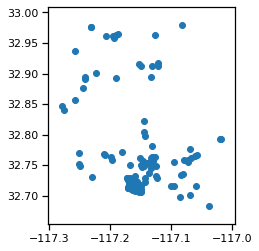

In [56]:
import geopandas as gpd
a = [a.as_dict() for a in c.assets_by_event('BICYCLE')]

bike_assets = gpd.GeoDataFrame(a).set_geometry('geometry')

gdf.plot();


Loading in the boundaries of San Diego communities allows us to do a geographic join, to determine what neighborhoods the resources are in. 

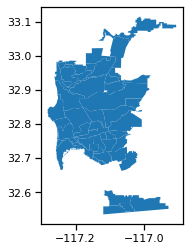

In [55]:
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-geography-2018-13.zip')
communities = pkg.resource('sd_community_boundaries').geoframe()
communities.plot()

Apparently, all of the cameras that record BICYCLE events are in the downtown area. 

In [64]:
bike_assets.crs = communities.crs # Because it was created with a CRS
bac =gpd.sjoin(bike_assets, communities).head()
bac.name.unique()

array(['Downtown'], dtype=object)

# Fetching Events

In [ ]:
bike

In [13]:
%%time
t = df[['timestamp', 'locationUid', 'measures.counter_direction_bicycleCount','measures.bicycleCount']]\
    .set_index('timestamp').groupby(['locationUid',pd.Grouper(freq='15T')]).sum().reset_index()
t.columns = ['locationUid', 'timestamp', 'bike_count_counter', 'bike_count']

CPU times: user 246 ms, sys: 22 ms, total: 268 ms
Wall time: 51.4 ms


In [14]:
t['bc'] = t.bike_count_counter + t.bike_count_counter
t.head()

,locationUid,timestamp,bike_count_counter,bike_count,bc
0,780b3ff2,2020-01-01 00:00:00-08:00,0.0,0.0,0.0
1,780b3ff2,2020-01-01 00:15:00-08:00,0.0,0.0,0.0
2,780b3ff2,2020-01-01 00:30:00-08:00,0.0,0.0,0.0
3,780b3ff2,2020-01-01 00:45:00-08:00,0.0,0.0,0.0
4,780b3ff2,2020-01-01 01:00:00-08:00,0.0,0.0,0.0


In [15]:
t.groupby('locationUid').bc.sum().sort_values(ascending=False).head(30)

locationUid
780b3ff2    0.0
Name: bc, dtype: float64

TypeError: no numeric data to plot

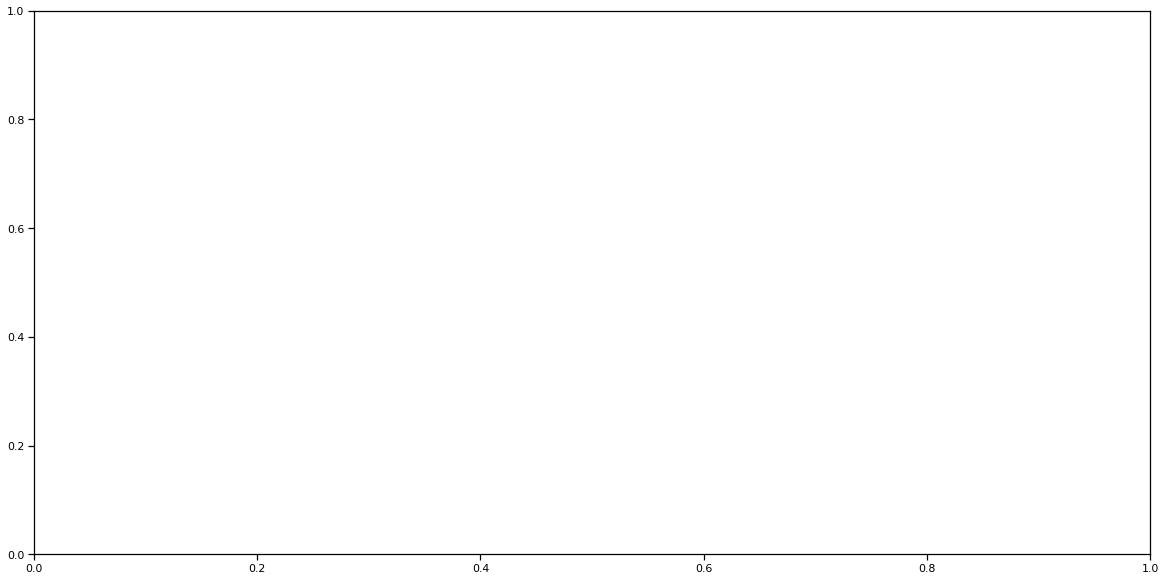

In [16]:
fig, ax = plt.subplots(figsize=(20,10))  

tl = t[t.locationUid == 'xx4x7o00c4mk5fo4but'].copy()
tl['time'] = tl.timestamp.dt.time
tl['date'] = tl.timestamp.dt.date
tl = tl.groupby('date').sum()
tl.bc.plot(ax=ax)

In [ ]:
%%time
td = df[['timestamp', 'locationUid', 'measures.counter_direction_bicycleCount','measures.bicycleCount']]\
    .set_index('timestamp').groupby(['locationUid',pd.Grouper(freq='D')]).sum().reset_index()
td.columns = ['locationUid', 'timestamp', 'bike_count_counter', 'bike_count']
len(td)

In [ ]:
td.groupby('locationUid').bc.sum().sort_values(ascending=False).head(20)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))  
td['bc'] = td.bike_count_counter + td.bike_count_counter
tl = td[td.locationUid == 'ndy4qdunwwmk1mhv26k'].set_index('timestamp').copy()
tl.bc.plot(ax=ax)

In [ ]:
import cityiq
from datetime import date, datetime 
c = cityiq.CityIq()

In [ ]:
datetime.min.time()